In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
import json
import configparser
from pathlib import Path
import os
import numpy as np

def RMSE(y_real, y_predict):
    return np.sqrt(MSE(y_real, y_predict))

In [2]:
configs = configparser.ConfigParser()
configs.read("../configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
qtd_Meses = int(configs["DEFAULT"]["meses"])
regiao = configs["DEFAULT"]["regiao"]

df = pd.read_excel(path, parse_dates=['ano'])
df.razao = df.razao * 100
train = df.iloc[-12-qtd_Meses::]
train = train.iloc[:-qtd_Meses + 1:]
val = df.iloc[-qtd_Meses::]

#models = ['RNN', 'LSTM', 'CNN', 'N-Beast', 'TFT']
models = ['RNNRecursivo', 'DeepRNN', 'LSTM', 'CNN', 'DeepLSTM']
resultados = {model:[] for model in models}

for model in models:
    with open(f'previsoes/previsao_{model}_cesta_basica_{regiao}_{qtd_Meses}_meses.json','r') as file:
        resultado = json.load(file)
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("[", "")
        resultado['cesta_basica'] = resultado['cesta_basica'].replace("]", "")
        temp = resultado['cesta_basica'].split(',')
        for valor in temp:
            resultados[model].append(float(valor) * 100)

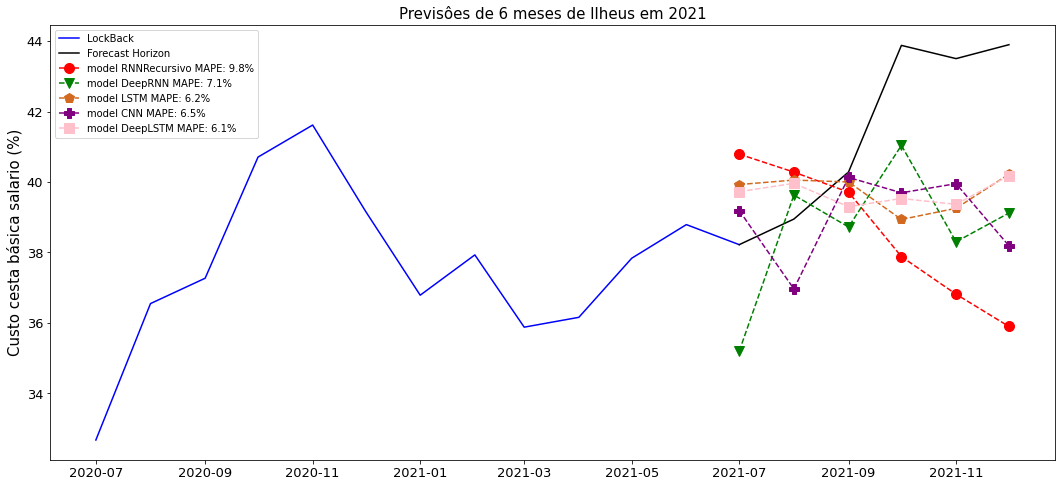

In [3]:
cores = ['red', 'green', 'chocolate', 'purple', 'pink']
markers = ['o', 'v', 'p', 'P', 's']

#xtickslabel = ['Jan', 'Fev', 'Mar','Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']
#ytickslabel = [float(valor) for valor in range(32, 50, 1)]

fig, ax = plt.subplots(1,1)
fig.set_figwidth(18)
fig.set_figheight(8)

#ax.plot(range(0, 24 - qtd_Meses + 1), train.razao, label = 'LockBack', color = 'blue')
#ax.plot(range(24 - qtd_Meses, 24), val.razao, label = 'Forecast Horizon', color = 'black')
ax.plot(train.ano.values, train.razao.values, label = 'LockBack', color = 'blue')
ax.plot(val.ano.values, val.razao.values, label = 'Forecast Horizon', color = 'black')
ax.set_ylabel("Custo cesta básica salario (%)", size = 15)

for model, cor, marker in zip(models, cores, markers):
    ax.plot(val.ano.values, resultados[model], label=f'model {model} MAPE: {100 * round(MAPE(val.razao, resultados[model]), 3)}%',
    color = cor, ls ='--', marker=marker, markersize=10)

#plt.xticks([x for x in range(0,12)], xtickslabel,size=13)
plt.xticks(size=13)
#plt.yticks(range(32, 50, 1), ytickslabel, size=13)
plt.yticks(size=13)

plt.title(f"Previsôes de {qtd_Meses} meses de {regiao} em 2021", size=15)
plt.legend(loc='upper left')
plt.savefig(fname=f'models_previsao_{qtd_Meses}_meses_{regiao}_.png')

In [4]:
metrics_index = ['MAE', 'MSE', 'RMSE', 'MAPE(%)']

resultados_metricas = {model:[] for model in models}

for model in models:
    for metric in [MAE, MSE, RMSE, MAPE]:
        if metric == MAPE:
            resultados_metricas[model].append(100 * round(metric(val.razao, resultados[model]), 5))
        else:
            resultados_metricas[model].append(round(metric(val.razao, resultados[model]), 5))

resultados_metricas = pd.DataFrame(resultados_metricas, index=metrics_index).T
resultados_metricas

,MAE,MSE,RMSE,MAPE(%)
RNNRecursivo,4.19228,25.55382,5.05508,9.803
DeepRNN,3.01334,11.65847,3.41445,7.139
LSTM,2.65995,10.02828,3.16675,6.234
CNN,2.75767,11.26333,3.35609,6.451
DeepLSTM,2.61682,9.01080,3.00180,6.143
